# Introduction

## Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import time

%matplotlib inline

## Modeling MDPs in TensorFlow

All classes defining MDPs must inherit from abstract class ```MDP```.

In [2]:
import abc

class MDP(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def transition(self, state, action):
        return

    @abc.abstractmethod
    def reward(self, state, action):
        return


### Navigation in 2D grid with deceleration zone at the center

In [3]:
class Navigation(MDP):

    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

        self.state_size = self.ndim

        # grid constants
        self.__size = tf.constant(self.size, dtype=tf.float32)
        self.__center = tf.constant(self.center, dtype=tf.float32)
        self.__goal = tf.constant(self.goal, dtype=tf.float32)

        # numerical constants
        self.__0_00 = tf.constant(0.00, dtype=tf.float32)
        self.__0_99 = tf.constant(0.99, dtype=tf.float32)
        self.__1_00 = tf.constant(1.00, dtype=tf.float32)
        self.__2_00 = tf.constant(2.00, dtype=tf.float32)
        self.__decay = tf.constant(self.decay, dtype=tf.float32)

    def transition(self, state, action):
        # distance to center of grid
        d = tf.sqrt(tf.reduce_sum(tf.square(state - self.__center), 1, keep_dims=True))

        # deceleration_factor
        deceleration = self.__2_00 / (self.__1_00 + tf.exp(-self.__decay * d)) - self.__1_00

        # next position
        next_state = state + deceleration * action
        next_state = tf.clip_by_value(next_state, self.__0_00, self.__size)

        return next_state

    def reward(self, state, action):
        return -tf.reduce_sum(tf.abs(state - self.__goal), 1, keep_dims=True)


min = 0.000500, max = 0.999909


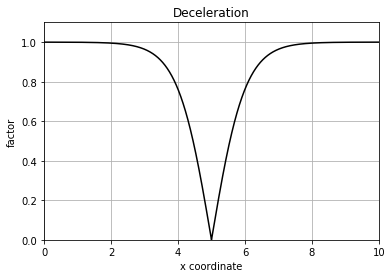

In [4]:
x = np.linspace(0, 10, 10000)
d = np.abs(x - 5.0)
y = 2 / (1 + np.exp(-2.0 * d)) - 1.00
print('min = {0:.6f}, max = {1:.6f}'.format(np.min(y), np.max(y)))

plt.plot(x, y, 'k-')
plt.axis([0.0, 10.0, 0.0, 1.1])
plt.xlabel('x coordinate')
plt.ylabel('factor')
plt.title('Deceleration')
plt.grid()

## Encoding an MDP as a Recurrent Neural Net

In [5]:
class MDP_RNNCell(tf.nn.rnn_cell.RNNCell):

    def __init__(self, mdp, batch_size):
        self.mdp = mdp
        self.batch_size = batch_size

    @property
    def state_size(self):
        return mdp.state_size

    @property
    def output_size(self):
        return mdp.state_size + 1

    def __call__(self, inputs, state, scope=None):
        actions = inputs
        next_state =  self.mdp.transition(state, actions)
        reward = self.mdp.reward(state, actions)
        return tf.concat([reward, next_state], 1), next_state


In [6]:
class MDP_RNN(object):
    
    def __init__(self, mdp, batch_size):
        self.cell = MDP_RNNCell(mdp, batch_size)
    
    def unroll(self, actions, initial_state=None):
        # set initial state 
        if initial_state is None:
            initial_state = self.cell.zero_state(self.cell.batch_size, dtype=tf.float32)

        # dynamic time unrolling
        outputs, final_state = tf.nn.dynamic_rnn(
            self.cell,
            actions,
            initial_state=initial_state,
            dtype=tf.float32)

        # separate reward and state series
        outputs = tf.unstack(outputs, axis=2)
        max_time = int(actions.shape[1])
        reward_series = tf.reshape(outputs[0], [-1, max_time, 1])
        state_series = tf.stack(outputs[1:], axis=2)

        return reward_series, state_series, final_state


## Defining the action optimizer

In [7]:
class ActionOptimizer(object):
    
    def __init__(self, loss, learning_rate=0.001, limits=None, actions=None):
        self.loss = loss

        # optimization hyperparameters
        self.learning_rate = learning_rate

        # action constraints
        self.limits = None
        if limits is not None:
            self.limits = tf.assign(actions, tf.clip_by_value(actions, limits[0], limits[1]))

        # backprop via RMSProp
        self.train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

    def run(self, sess, epoch=100, show_progress=True):
        # initialize variables
        sess.run(tf.global_variables_initializer())
        
        losses = []
        for epoch_idx in range(epoch):
            # backprop and update weights
            sess.run(self.train_step)

            # maintain action constraints if any
            if self.limits is not None:
                sess.run(self.limits)

            # store and show loss information
            loss = sess.run([self.loss])
            losses.append(loss)
            if show_progress:
                print('Epoch {0:5}: loss = {1}\r'.format(epoch_idx, loss), end='')
        
        return losses


## Putting all together

### Instantiate the MDP model

In [8]:
params = {
    'ndim': 2,
    'size': (10.0, 10.0),
    'initial': (1.0, 5.0),
    'goal': (8.0, 5.0),
    'center': (5.0, 5.0),
    'decay': 1.5,
    'limits': (-1.0, 1.0)
}

# MDP model
mdp = Navigation(**params)


### Unroll the RNN for a given horizon

In [9]:
batch_size = 1000  # number of parallel planners
max_time = 10      # horizon
state_size = 2     # grid 2D

# actions to optimize
actions = tf.Variable(
    tf.truncated_normal(shape=[batch_size, max_time, state_size], stddev=0.05),
    name="actions")

# initial state
x_initial, y_initial = params['initial']
x_initial = tf.fill([batch_size], tf.constant(x_initial, tf.float32))
y_initial = tf.fill([batch_size], tf.constant(y_initial, tf.float32))
initial_state = tf.stack([x_initial, y_initial], axis=1)

# unrolled MDP model
rnn = MDP_RNN(mdp, batch_size)
rewards, states, final_state = rnn.unroll(actions, initial_state)


### Define the optimization loss function

In [10]:
# loss based on total reward
total = tf.reduce_sum(rewards, 1)
loss = tf.reduce_mean(tf.square(total))

# index of best solution among all planners
best_batch_idx = tf.argmax(total,0)


### Optimize it!

In [11]:
# config
limits = tf.constant(params['limits'], dtype=tf.float32)

start = time.time()

# optimize, babe!
with tf.Session() as sess:
    epoch = 500
    learning_rate = 0.01
    losses = ActionOptimizer(loss, learning_rate, limits, actions).run(sess, epoch)

    # getting results
    best_batch_idx = sess.run(best_batch_idx)
    final_state = np.squeeze(sess.run(final_state)[best_batch_idx])
    cost = np.squeeze(sess.run(total)[best_batch_idx])

    plan = np.squeeze(sess.run(actions)[best_batch_idx])
    s_series = np.squeeze(sess.run(states)[best_batch_idx])
    r_series = np.squeeze(sess.run(rewards)[best_batch_idx])

end = time.time()
print()
print("Done in {0:.6f} sec".format(end-start))

Epoch   499: loss = [1234.0863]
Done in 17.431025 sec


## Visualizing results

In [12]:
# reporting results
print("Final state =", final_state)
print("Cost =", cost)
print()

print("Action, State, Reward")
for a, s, r in zip(plan, s_series, r_series):
    print("[{0:-10.6f}, {1:-10.6f}]".format(a[0], a[1]), end=', ')
    print("[{0:-10.6f}, {1:-10.6f}]".format(s[0], s[1]), end=', ')
    print("{0:-10.6f}".format(r))
    

Final state = [ 8.08867455  4.92262936]
Cost = -35.01970672607422

Action, State, Reward
[  1.000000,  -0.001510], [  1.995055,   4.998497],  -7.000000
[  1.000000,  -0.004920], [  2.973242,   4.993685],  -6.006448
[  1.000000,  -0.645272], [  3.881953,   4.407319],  -5.033073
[  1.000000,  -0.974798], [  4.621314,   3.686592],  -4.710728
[  1.000000,   0.074765], [  5.393283,   3.744308],  -4.692094
[  1.000000,   0.993567], [  6.149312,   4.495473],  -3.862409
[  1.000000,   0.697402], [  6.885168,   5.008660],  -2.355216
[  0.999825,  -0.009679], [  7.773330,   5.000062],  -1.123493
[  0.240548,  -0.003190], [  8.006484,   4.996970],  -0.226732
[  0.084019,  -0.075995], [  8.088675,   4.922629],  -0.009514


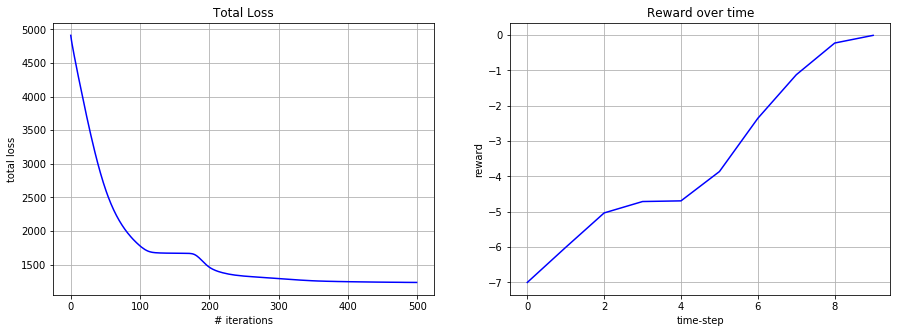

In [13]:
plt.figure(figsize=(15, 5))

# plotting losses
plt.subplot(121)
plt.plot(losses, 'b-')
plt.title('Total Loss')
plt.xlabel("# iterations")
plt.ylabel("total loss")
plt.grid()

# plotting rewards
plt.subplot(122)
plt.plot(r_series, 'b-')
plt.title("Reward over time")
plt.xlabel("time-step")
plt.ylabel("reward")
plt.grid()


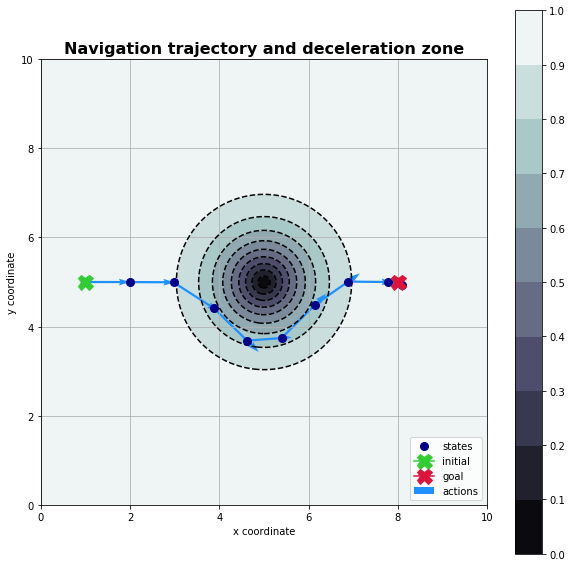

In [14]:
# params
xlim, ylim = params['size']
xcenter, ycenter = params['center']
start, end = params['initial'], params['goal']

# plot configuration
plt.figure(figsize=(10, 10))
plt.axis([0.0, xlim, 0.0, ylim])
plt.axes().set_aspect('equal')
plt.grid()
plt.title("Navigation trajectory and deceleration zone", fontweight="bold", fontsize=16)
plt.xlabel("x coordinate")
plt.ylabel("y coordinate")

# deceleration zone
npoints = 1000
X, Y = np.meshgrid(np.linspace(0.0, xlim, npoints), np.linspace(0.0, ylim, npoints))
D = np.sqrt((X - xcenter) ** 2 + (Y - ycenter) ** 2)
Lambda = 2 / (1 + np.exp(-params['decay'] * D)) - 1.00

ticks = np.arange(0.0, 1.01, 0.10)
cp = plt.contourf(X, Y, Lambda, ticks, cmap=plt.cm.bone)
plt.colorbar(cp, ticks=ticks)
cp = plt.contour(X, Y, Lambda, ticks, colors='black', linestyles='dashed')
# plt.clabel(cp, inline=True, fontsize=10)

# actions
positions = np.concatenate([[start], s_series])
plt.quiver(positions[:-1, 0], positions[:-1, 1], plan[:, 0], plan[:, 1],
           angles='xy', scale_units='xy', scale=1, color='dodgerblue', width=0.005,
           label='actions')

# states
plt.plot(positions[:, 0], positions[:, 1], 'o', color='darkblue', markersize=8, label='states')

# start and end
plt.plot([start[0]], [start[1]], marker='X', markersize=15, color='limegreen', label='initial')
plt.plot([end[0]], [end[1]], marker='X', markersize=15, color='crimson', label='goal')

plt.legend(loc='lower right')
plt.show()